In [1]:
def enable_parent_folder_import():
    import sys, os
    sys.path.insert(1, os.path.join(sys.path[0], '..'))

enable_parent_folder_import()

In [2]:
# VISUALIZATION CODE
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
# Result heatmap

# Build grid with all particles
def get_grid(vector):
    size = int(np.ceil(np.sqrt(len(vector))))
    grid = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            idx = i * size + j
            if idx < len(vector):
                grid[i][j] = vector[idx]
    
    return grid

def visualize_dataset(dataset, same_color_axis = False, title = "Normalized Density vs. Normalized Density Gradient"):

    fig = make_subplots(rows=1, cols=2)
    grid1 = get_grid(dataset.data)
    grid2 = get_grid(dataset.target)

    if same_color_axis:
        fig.add_trace(go.Heatmap(z=grid1, coloraxis = "coloraxis"), row=1, col=1)
        fig.add_trace(go.Heatmap(z=grid2, coloraxis = "coloraxis"), row=1, col=2)
        fig.update_layout(coloraxis = {'colorscale':'plasma'})
    else:
        fig.add_trace(go.Heatmap(z=grid1), row=1, col=1)
        fig.add_trace(go.Heatmap(z=grid2), row=1, col=2)

    fig.update_layout(title_text=title)

    fig.show()

def visualize_model_fig(model,
                    dataset,
                    same_color_axis = False,
                    title = None,
                    subplot_titles = ('Densities',  'Target density gradient', 'Predicted density gradient')):
    # Compare output
    d = dataset

    result = model(d.get_points(), d.data.view(-1, 1))
    grid_result = get_grid(result.detach().numpy())
    grid_target = get_grid(d.target)
    grid_data = get_grid(d.data)

    # https://stackoverflow.com/a/58853985
    fig = make_subplots(rows=1,
                        cols=3,
                        subplot_titles=subplot_titles)
    if same_color_axis:
        fig.add_trace(go.Heatmap(z=grid_data, coloraxis = "coloraxis"), row=1, col=1)
        fig.add_trace(go.Heatmap(z=grid_target, coloraxis = "coloraxis"), row=1, col=2)
        fig.add_trace(go.Heatmap(z=grid_result, coloraxis = "coloraxis"), row=1, col=3)
        fig.update_layout(coloraxis = {'colorscale':'plasma'})
    else:
        fig.add_trace(go.Heatmap(z=grid_data), row=1, col=1)
        fig.add_trace(go.Heatmap(z=grid_target), row=1, col=2)
        fig.add_trace(go.Heatmap(z=grid_result), row=1, col=3)
    
    if title is not None:
        fig.update_layout(title_text=title, width=1000, height=400)
    
    return fig

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io

def make_static_img(fig):
    png = fig.to_image(format="png")
    iobytes = io.BytesIO(png)

    plt.figure(figsize=(fig.layout.width, fig.layout.height), dpi=1)

    img = mpimg.imread(iobytes)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def visualize_model(model,
                    dataset,
                    same_color_axis = False,
                    title = None,
                    subplot_titles = ('Densities',  'Target density gradient', 'Predicted density gradient')):
    
    fig = visualize_model_fig(model, dataset, same_color_axis, title, subplot_titles)
    return fig

#visualize_dataset(dataset["train"], same_color_axis=True)
#visualize_model(model, dataset["train"], same_color_axis=False)
#visualize_model(model, dataset["train"], same_color_axis=True)


# Model test

In [3]:
import pyvista as pv
import torch
import torch.nn as nn
import torch.nn.functional as F
import open3d.ml.torch as ml3d

class MyCConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin_embedding = nn.Linear(1,8)  # Todo: nn.Embedding(1, 8) see https://stackoverflow.com/a/65448744
        self.cconv = ml3d.layers.ContinuousConv(in_channels=8, filters=16, kernel_size=[3,3,3])
        self.lin_out_mapping = nn.Linear(16, 1)
        self.nonlin = nn.ReLU()

    def forward(self, particle_positions, x):
        # conv(inp_features, inp_positions, out_positions, extents=2.0)
        
        # Todo: this probably causes particles to find themselves as neighbours. Fix this.
        x = self.lin_embedding(x)
        x = self.cconv(x, particle_positions, particle_positions, extents=2.0)
        x = self.nonlin(x)
        x = self.lin_out_mapping(x)
        return x



# 1. Datasets
# TODO: ADD VELOCITY AS DATA!
class VtkDataset(torch.utils.data.Dataset):
    # Todo, we need the torch tensors
    # Todo, shuffle, batching, etc.

    def __init__(self, path, jitter=0.0):
        if jitter != 0.0:
            self.add_noise(jitter)

        self.path = path
        self.mesh = pv.UnstructuredGrid(path)
        self.data = self.normalize(torch.tensor(self.mesh.point_data["density"]))
        self.target = self.normalize(torch.tensor(self.mesh.point_data["density_grad"]))
        self.n_points = self.mesh.n_points

    def __len__(self):
        return self.n_points

    def __getitem__(self, idx):
        # Care: Does this return dangling references? Probably!
        return torch.tensor(self.data[idx]).view(-1), torch.tensor(self.target[idx]).view(-1)
    
    def add_noise(self, noise):
        raise Exception("TODO: Implement noise")
    
    def get_points(self):
        return torch.tensor(self.mesh.points)
    
    def normalize(self, data):
        mean = torch.mean(data)
        std = torch.std(data)
        return (data - mean) / (std + 1e-8)
    


# 2. Implement solver
class Solver():
    def __init__(self, model, train_data, eval_data, optimizer, loss_function = nn.MSELoss()):
        self.model = model
        self.train_data = train_data
        self.eval_data = eval_data
        self.criterion = loss_function
        self.optimizer = optimizer
        self.loss_history = []
        self.eval_loss_history = []

    def train(self, epochs):
        self.model.train()
        # running_loss = 0.0
        # running_eval_loss = 0.0
        sample_count = len(self.train_data)

        for epoch in range(epochs):
            self.optimizer.zero_grad()

            points = self.train_data.get_points()
            inputs = self.train_data.data.view(-1, 1)
            targets = self.train_data.target.view(-1, 1)

            output = self.model(points, inputs)
            loss = self.criterion(output, targets)

            loss.backward()
            self.optimizer.step()

            self.loss_history.append(loss.item())
            self.eval_loss_history.append(self.eval_loss())

            if epoch % 100 == 0:
                print("Epoch {} - Train loss: {}, Eval loss: {}".format(epoch, loss.item(), self.eval_loss()))

        self.model.eval()

    def eval_loss(self):
        points = self.eval_data.get_points()
        inputs = self.eval_data.data.view(-1, 1)
        targets = self.eval_data.target.view(-1, 1)

        network_output = self.model(points, inputs)
        eval_loss = self.criterion(network_output, targets).item()

        return eval_loss
    
    def plot_loss(self):
        import plotly.graph_objects as go

        fig = go.Figure()
        fig.add_trace(go.Scatter(y=self.loss_history, name="Train loss"))
        fig.add_trace(go.Scatter(y=self.eval_loss_history, name="Eval loss"))
        fig.update_layout(title_text="Loss", width=1000, height=650)
        return fig


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
dataset = {
    # Care: there probably is almost no generalization with all datasets being this similar
    "train": VtkDataset("../datasets/data/DamBreakModel_2D/ParticleData_Fluid_12.vtk"),
    "eval": VtkDataset("../datasets/data/DamBreakModel_2D/ParticleData_Fluid_13.vtk"),
    "test": VtkDataset("../datasets/data/DamBreakModel_2D/ParticleData_Fluid_14.vtk")
}

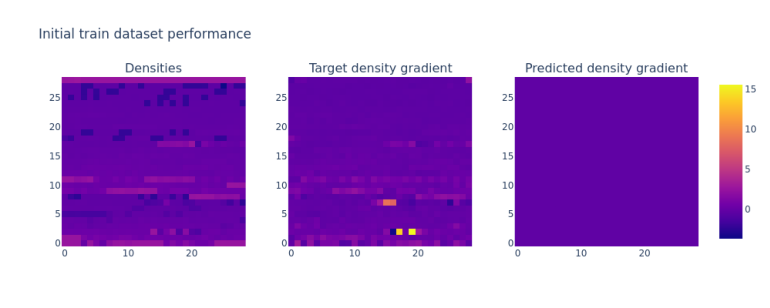

Epoch 0 - Train loss: 1.0600799322128296, Eval loss: 1.0182738304138184
Epoch 100 - Train loss: 0.6392821669578552, Eval loss: 0.7509396076202393
Epoch 200 - Train loss: 0.35203030705451965, Eval loss: 0.718709409236908
Epoch 300 - Train loss: 0.2837314009666443, Eval loss: 0.7657186985015869
Epoch 400 - Train loss: 0.2459457516670227, Eval loss: 0.8815321922302246
Epoch 500 - Train loss: 0.227314293384552, Eval loss: 0.8769810795783997
Epoch 600 - Train loss: 0.21252621710300446, Eval loss: 0.908722996711731
Epoch 700 - Train loss: 0.18945488333702087, Eval loss: 0.9763737320899963
Epoch 800 - Train loss: 0.18301796913146973, Eval loss: 1.071513056755066
Epoch 900 - Train loss: 0.2042883187532425, Eval loss: 1.130820870399475
Epoch 1000 - Train loss: 0.14584876596927643, Eval loss: 1.042447805404663
Epoch 1100 - Train loss: 0.14055323600769043, Eval loss: 1.1301220655441284
Epoch 1200 - Train loss: 0.1501794308423996, Eval loss: 1.2467690706253052
Epoch 1300 - Train loss: 0.1314510554

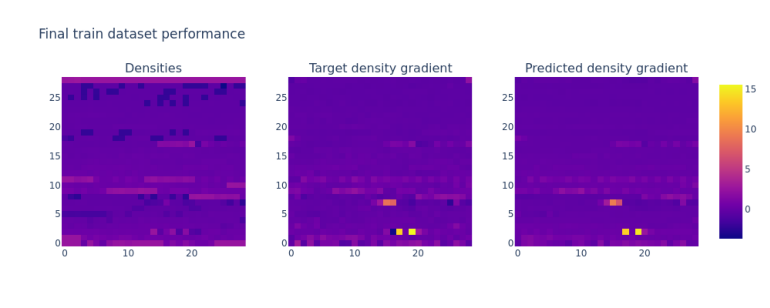

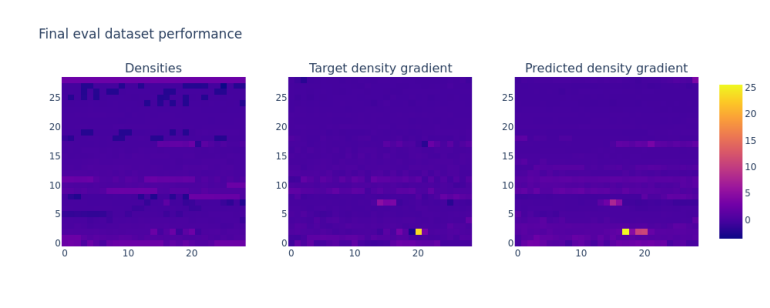

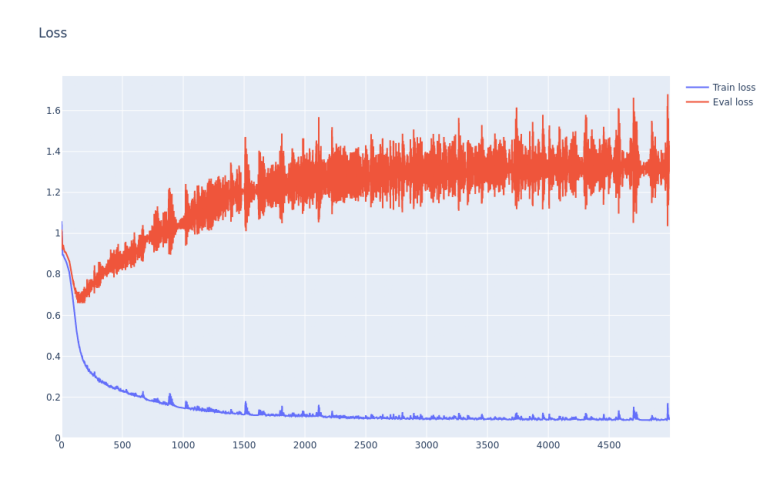

In [11]:
model = MyCConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
solver = Solver(model, dataset["train"], dataset["eval"], optimizer)

make_static_img(visualize_model(model, dataset["train"], same_color_axis=True, title = "Initial train dataset performance"))
solver.train(epochs = 5000)
make_static_img(visualize_model(model, dataset["train"], same_color_axis=True, title = "Final train dataset performance"))
make_static_img(visualize_model(model, dataset["eval"], same_color_axis=True, title = "Final eval dataset performance"))
make_static_img(solver.plot_loss())